# Comparison of thin plate spline and its Laplacian approximation in 2D

This notebook reproduces figures from the paper

In [9]:
using LinearAlgebra, SparseArrays, LaplaceInterpolation
using TestImages, Colors, BenchmarkTools, ImageIO
using Plots, ThinPlateSplines, PolyharmonicSplines, Random

## Mandrill 2D Example

Here we load in the mandrill test image and discard roughly 75% of the data.

There are 129540 interior nodes, and 1534 boundary nodes.
We discard 76.2939453125 percent of the data.


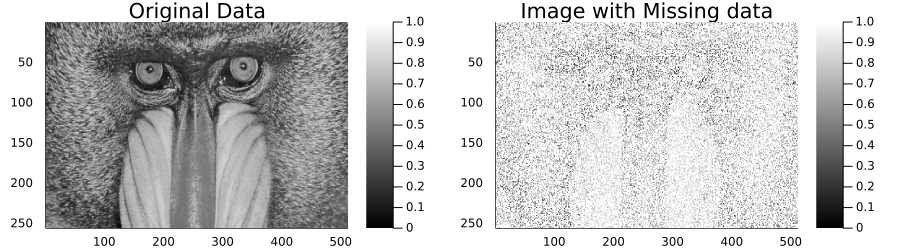

In [10]:
# Example from TestImages package
img = testimage("mandrill")

# Flatten the image to grayscale and select a subset of the image
imgg = Float64.(Gray.(img))
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]

println("There are $((rows - 2) * (columns - 2)) interior nodes, and $(2 * rows + 2 * columns - 2) boundary nodes.")

No_of_nodes_discarded = 100000

println("We discard $(100.0 * No_of_nodes_discarded / N) percent of the data.")

discard = randperm(N)[1:No_of_nodes_discarded]

holeyimage1 = copy(mat)
holeyimage1[discard] .= 1

p1 = heatmap(mat, title = "Original Data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p2 = heatmap(holeyimage1, title = "Image with Missing data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))

plot(p1, p2, layout = (1,2), size = (900, 250))

# Reconstruction using Matern and Laplace interpolations

In [11]:
h = k = 1.0
restored_img_laplace = matern_2d_grid(mat, discard, 1, 0.0)
restored_img_matern = matern_2d_grid(mat, discard, 2, 0.0)

256×512 Array{Float64,2}:
 0.440585   0.392063  0.294907  0.204095  …  0.65456   0.683977  0.694118
 0.437323   0.396078  0.291159  0.18892      0.648145  0.671355  0.679618
 0.416356   0.379098  0.293868  0.180392     0.624598  0.64489   0.651761
 0.392254   0.383545  0.364407  0.276277     0.602114  0.614883  0.619341
 0.341176   0.377728  0.485772  0.417885     0.600068  0.594008  0.595669
 0.207579   0.298039  0.623529  0.591819  …  0.639619  0.596078  0.597129
 0.105121   0.2       0.520511  0.61958      0.72549   0.669868  0.635102
 0.101877   0.218585  0.465402  0.6          0.642775  0.629089  0.604917
 0.100341   0.188235  0.347527  0.429031     0.529412  0.520136  0.508628
 0.0908999  0.12549   0.244678  0.30699      0.387333  0.382543  0.387091
 0.129412   0.156857  0.223529  0.245936  …  0.254902  0.277889  0.30169
 0.129412   0.195901  0.250603  0.237543     0.278154  0.290196  0.306319
 0.169908   0.262745  0.326405  0.27152      0.357941  0.372549  0.376391
 ⋮           

# Reconstruction Errors

In [12]:
error_lap = abs.(restored_img_laplace .- mat)
error_mat = abs.(restored_img_matern .- mat)

rel_error_lap = abs.((restored_img_laplace .- mat) ./ mat)
rel_error_mat = abs.((restored_img_matern .- mat) ./ mat);

# Plotting and Saving

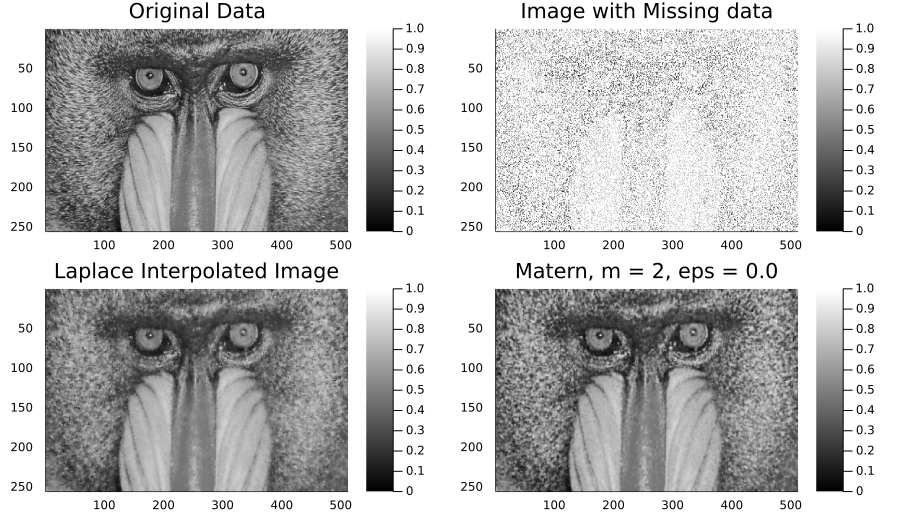

In [13]:
p3 = heatmap(restored_img_laplace, title = "Laplace Interpolated Image", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p4 = heatmap(restored_img_matern, title = "Matern, m = 2, eps = 0.0", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
plot(p1, p2, p3, p4, layout = (2, 2), legend = false, size = (900, 520))

# png("Mandrill_Random.png")

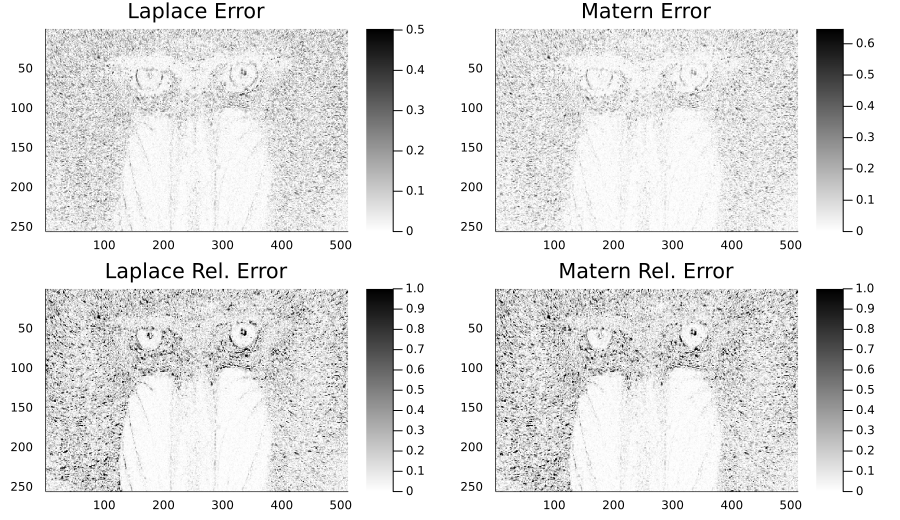

In [14]:
plot1 = heatmap(error_lap, c = :binary, yflip = true, title = "Laplace Error", pointsize = 15)
plot2 = heatmap(error_mat, c = :binary, yflip = true, title = "Matern Error", pointsize = 15)

plot3 = heatmap(rel_error_lap, yflip = true, title = "Laplace Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))
plot4 = heatmap(rel_error_mat, yflip = true, title = "Matern Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))

plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false, size = (900, 520))
# png("Mandrill_Random_Errors.png")

# Remove islands of data

In [15]:
cent = [(100, 200), (200, 100)]
rad = 20*ones(Int64, 2)

discard2 = punch_holes_2D(cent, rad, rows, columns);

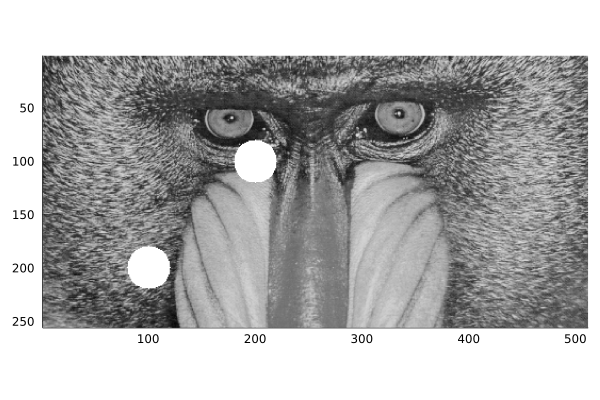

In [16]:
holeyimage = copy(mat)
holeyimage[discard2] .= 1.0
Plots.plot(Gray.(holeyimage))

## Interpolate in small chunks around the punches

The polyharmonic spline is so dense that it does not run. The only way it will run is if we break the problem down.

In [25]:
# code from https://github.com/lstagner/PolyharmonicSplines.jl
include("polyharmonic_splines.jl")

function tps_interpolate(cent, rad, holeyimage)
    xarray = Float64[]
    yarray = Float64[]
    zarray = Float64[]
    clen = length(cent)
    for (i,c) in enumerate(cent)
        for x in (c[1] .- rad[i]):(c[1] .+ rad[i])
            for y in (c[2] .- rad[i]):(c[2] .+ rad[i])
                if ((x - c[1])^2 + (y - c[2])^2 > rad[i]^2)
                    xarray = append!(xarray, x)
                    yarray = append!(yarray, y)
                    zarray = append!(zarray, mat[y,x])
                end
            end
        end
    end
    # idx = hcat(collect.(Tuple.(CartesianIndices(holeyimage)[punch_holes_2D(cent, rad, size(holeyimage)...)]))...)
    # S2 = PolyharmonicSpline(2, Float64.(idx), holeyimage[idx][:])
    S2 = PolyharmonicSpline(2, [xarray yarray], zarray)
    holeyimage_copy = copy(holeyimage)
    for (i,c) in enumerate(cent)
        x = ones(2*rad[i] + 1)*((c[1]-rad[i]):(c[1]+rad[i]))'
        xx = reshape(x,(2*rad[i] + 1)^2)
        y = ((c[2]-rad[i]):(c[2]+rad[i]))*ones(2*rad[i] + 1)'
        yy = reshape(y,(2*rad[i] + 1)^2)
        zz = interpolate(S2,xx,yy)
        zz_reshape = reshape(zz, (2*rad[i] + 1), (2*rad[i] + 1))
        count = 1
        for k in (c[1]-rad[i]):(c[1]+rad[i])
            for j in (c[2] - rad[i]):(c[2] + rad[i])
                holeyimage_copy[j,k] = zz[count]
                count += 1
            end
        end
    end
    return holeyimage_copy
end
    

@benchmark begin
    tps_interpolate(cent, rad, holeyimage)
end


BechmarkTools.Trial: 6 samples with 1 evaluations.
 Range (min … max):  844.165 ms …   1.020 s  ┊ GC (min … max): 12.06% … 25.17%
 Time  (median):     868.398 ms              ┊ GC (median):    13.10%
 Time  (mean ± σ):   889.419 ms ± 66.908 ms  ┊ GC (mean ± σ):  15.03% ±  5.17%

  █  ▁        ▁   ▁                                          ▁▁ 
  █▁▁█▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  844 ms          Histogram: frequency by time           120 s <

 Memory estimate: 1.22 GiB, allocs estimate: 12869356.

In [39]:
function foo(holeyimage, cent, rad)
    holeyimage_copy_m = copy(holeyimage)
    for i = 1:length(cent)
        indx = (cent[i][1]-rad[i]):(cent[i][1]+rad[i])
        indy = (cent[i][2]-rad[i]):(cent[i][2]+rad[i])
        num = (2*rad[i] + 1)
        discard = punch_holes_2D([(rad[i] + 1, rad[i] + 1)], rad[i], num, num)
        holeyimage_copy_m[indx, indy] = matern_2d_grid(mat[indx, indy], discard, 2, 0.0, 1.0, 1.0) 
    end
    return holeyimage_copy_m
end

@benchmark begin
    foo(holeyimage, cent, rad)
end

BechmarkTools.Trial: 444 samples with 1 evaluations.
 Range (min … max):   9.802 ms … 19.908 ms  ┊ GC (min … max): 0.00% … 15.67%
 Time  (median):     10.946 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.249 ms ±  1.212 ms  ┊ GC (mean ± σ):  3.41% ±  6.22%

    ▂▂▅▄▆▅▁▁▁▆▃▃▁█  ▁                                          
  ▆▇███████████████▅█▆▄▄▄▄▇▂▅▄▃▄▄▃▄▄▄▄▃▃▄▄▃▄▃▃▃▂▃▃▁▂▁▁▁▁▁▂▁▁▂ ▄
  9.8 ms          Histogram: frequency by time        15.2 ms <

 Memory estimate: 12.83 MiB, allocs estimate: 9256.

## Comparison of errors between Thin plate spline and Matern Interpolation

In [40]:
holeyimage_copy_m = foo(holeyimage, cent, rad);

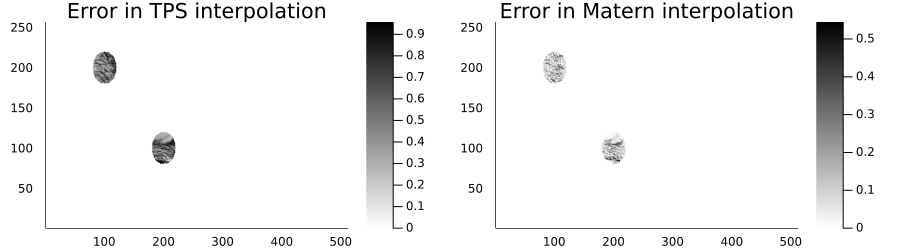

In [41]:
Error_TPS = abs.(mat .- holeyimage)
Error_Matern = abs.(mat .- holeyimage_copy_m)

plot1 = heatmap(Error_TPS, c = :binary, title = "Error in TPS interpolation")
plot2 = heatmap(Error_Matern, c = :binary, title = "Error in Matern interpolation")

plot(plot1, plot2, layout = (1, 2), legend = false, size = (900, 250))
# png("Mandrill_Errors.png")